# Predicting Sentiment Tweets

---
embed-resources: true
---

## Introduction

Today, I will be making a model that will alert airline customer services to respond to negative posts on twitter, or tweets, and acknowledge positive tweets from people. This model only works for the available dataset.

## Methods

In [23]:
# importsimport numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint
from sklearn.metrics import ConfusionMatrixDisplay

### Data

In [24]:
# load data
tweets_train = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-train.parquet",
)
tweets_test = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-test.parquet",
)
tweets_train

,sentiment,airline,text
8318,positive,Delta,@JetBlue Then en route to the airport the rebo...
3763,negative,United,@united now you've lost my bags too. At least...
9487,neutral,US Airways,"@USAirways Hi, can you attach my AA FF# 94LXA6..."
2591,positive,United,"@United, will you fill it? Yes they will. Than..."
12887,negative,American,@AmericanAir thanks! I hope we get movies. Tv'...
...,...,...,...
3416,negative,United,@united Can i get a refund? I would like to bo...
279,neutral,Virgin America,@VirginAmerica what is your policy on flying a...
1814,negative,United,@united I'm not sure how you can help. Your fl...
29,neutral,Virgin America,@VirginAmerica LAX to EWR - Middle seat on a r...


In the train data above, each row represents a tweet and shows the tweet itself, what airline it was sent to, and its sentiment level. The variables in the data are:

### Response 

**`Sentiment`**

- [object] the sentiment of the tweet. One of negative, neutral, or positive.


### Features

**`Text`**

- [object] the full text of the tweet.

### Additional Variables

**`Airline`**

- [object] the airline the tweet was “sent” to.

In the train data, we have 8235 different tweets, what type of sentiment it was, and the airline it was sent to

In [25]:
# summary statistics
count = tweets_train['airline'].value_counts()
porp = count / 8235
print(count)
print("")
print(porp)

airline
United            2166
US Airways        1664
American          1551
Southwest         1347
Delta             1239
Virgin America     268
Name: count, dtype: int64

airline
United            0.263024
US Airways        0.202064
American          0.188342
Southwest         0.163570
Delta             0.150455
Virgin America    0.032544
Name: count, dtype: float64


The data above shows how many tweets were sent to each airline and the proportion it took up in the train data

In [26]:

vec = CountVectorizer(vocabulary=['cancelled', 'please', 'thanks'])
word_counts = vec.fit_transform(tweets_train['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vec.get_feature_names_out())
word_totals = word_counts_df.sum()

print(word_totals)

cancelled    595
please       325
thanks       587
dtype: int64


The data above shows how many of each of the chosen words were appeared in the train data

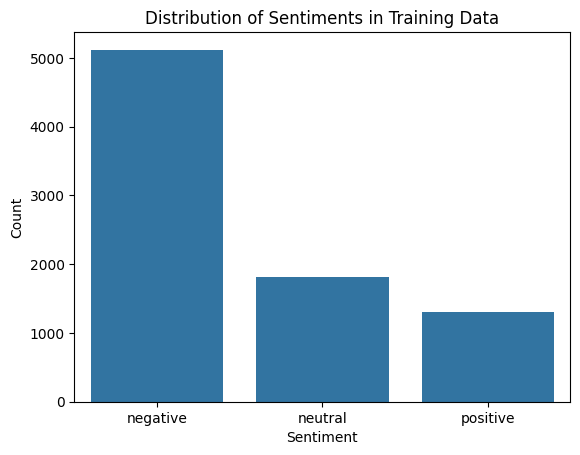

In [27]:
# exploratory visualization
sns.countplot(data=tweets_train, x='sentiment', order=tweets_train['sentiment'].value_counts().index)
plt.title('Distribution of Sentiments in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

From the graph above, most of our train data consists of negative sentiment tweets. This could foreshadow our model may not be so accurate due to the train data having a majority of one variable. Since there is a lot of negative sentiment tweets, the model will learn those negative sentiment patterns more than neutral and positive because there aren't too many tweets in those categories.

### Models

In [28]:
# process data for ML
# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

tweets_vtrain, tweets_validation = train_test_split(
    tweets_train,
    test_size=0.36,
)

X_validation = tweets_validation["text"]
y_validation = tweets_validation["sentiment"]

#create x and y for validation train
X_vtrain = tweets_vtrain["text"]
y_vtrain = tweets_vtrain["sentiment"]


I will split the train and test data once more into validation datasets to get more accurate results

In [29]:
#train models
pipeline = Pipeline([
    ('vec', CountVectorizer(lowercase= True)),  
    ('clf', LogisticRegression(max_iter=200))  
])


param_grid = {
    'vec__max_features': [1, 100, 300, 500, 1000, 2000, 5000, 10000, 15000, 20000, 30000],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.0001, 0.01, 0.1, 1, 10],           
}

model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1)

_ = model.fit(X_vtrain, y_vtrain)
first_pred = model.predict(X_validation)
first_test_accuracy = accuracy_score(y_validation, first_pred)
print(f"First Test accuracy: {first_test_accuracy}")

First Test accuracy: 0.7851602023608769


When conducting the first test accuracy on the validation sets, we are able to see which parameters worked best on our model. We will use the best parameters on the final prediction on the test data

## Results

In [30]:
# report model metrics
best_params = model.best_params_
final_model = Pipeline([
    ('vec', CountVectorizer(
        lowercase=True,
        max_features=best_params['vec__max_features'],
        ngram_range=best_params['vec__ngram_range']
    )),
    ('clf', LogisticRegression(
        max_iter=200,
        C=best_params['clf__C']
    ))
])
_ = final_model.fit(X_train, y_train)
pred_test = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, pred_test)
print(f"Final Test Accuracy: {final_accuracy}")

Final Test Accuracy: 0.8014571948998178


We were able to achieve a final test accuracy score of 0.8014 with the model having the best parameters

In [32]:
# serialize model
dump(final_model, 'tweets.joblib')

['tweets.joblib']

## Discussion

For our final model, it was able to achieve an accuracy score of 0.8014. This means that when the model is predicting a tweet's sentiment level, it will correctly predict the sentiment level 80.14% of the time.

This accuracy score is okay but it is not optimal enough to be used. Only getting 80% correct of sentiment levels is not good and could cause many of the tweets to be predicted incorrectly. The reason for this low accuracy is because the data we have is very imbalanced. In other words, there too much of one category. From the summary statistics seen above, we see that we have way more negative tweets. Almost half of the data we used consists of negative tweets which makes sense as to why the model's accuracy not being good enough. Since there aren't that much positive and neutral tweets to learn from, it will be harder for the model to detect any patterns for positive and neutral tweets.

One way to improve the accuracy score is to add more data specifically for positive and neutral tweets. Having an even number of each type of tweet will help the model learn better and see patterns more for each type of tweet.

The confusion matrix can also help us how well the model did. When looking at the negative tweets, the model was able to correctly identify the negative tweets pretty well. This makes sense due to having so many negative tweets in the data. It also did a decent job of predicting positive comments as well but it struggled a bit on correctly identifying neutral tweets. The model only has an accuracy score of 63.28% when trying to predict neutral comments which is not good at all.

Overall, we should not use this model because the accuracy score is too low and it can be annoying when the model predicts so many tweet sentiment levels incorrectly. In order to maximize accuracy, we should be aiming for higher accuracy scores like above 95%. 

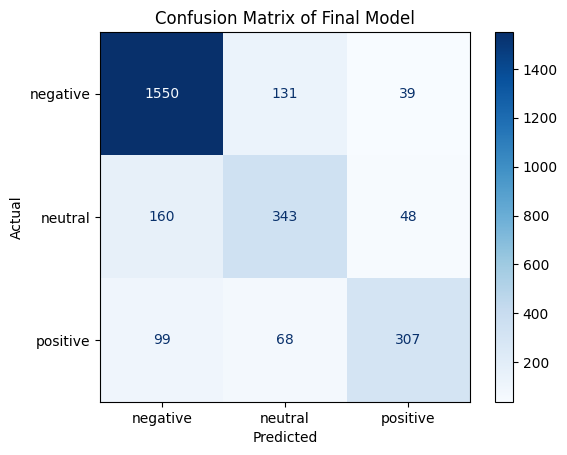

In [34]:
# summary figure
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=final_model.classes_, cmap='Blues')
plt.title('Confusion Matrix of Final Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()